In [93]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shap
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [94]:
df_train_1 = pd.read_csv("./ERODOS_mental_health_data/merged/all_data_train.csv")
df_train_2 = pd.read_csv("./ERODOS_mental_health_data/merged/all_data_additional_train.csv")
df_val_1 = pd.read_csv("./ERODOS_mental_health_data/merged/all_data_validation.csv")

df_train = pd.concat([df_train_1, df_train_2])
df_val = df_val_1

df_train['educ_par_max'] = df_train[['educ_par1', 'educ_par2']].max(axis=1)
df_val['educ_par_max'] = df_val[['educ_par1', 'educ_par2']].max(axis=1)

### Code for Flourish

In [137]:
df_clean_train = df_train[['flourish', 'fincur','age','gender','race', 'educ_par_max', 'residenc', 'international', 'degree', 'gpa_sr', 'alc_any', 'exerc']]
df_clean_train = df_clean_train.dropna()

mask = df_clean_train['gpa_sr'] < 6
df_clean_train = df_clean_train[mask]
df_clean_train['gpa_sr'] = df_clean_train['gpa_sr']*2
df_clean_train = df_clean_train.astype('int64')

df_clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131372 entries, 0 to 90081
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   flourish       131372 non-null  int64
 1   fincur         131372 non-null  int64
 2   age            131372 non-null  int64
 3   gender         131372 non-null  int64
 4   race           131372 non-null  int64
 5   educ_par_max   131372 non-null  int64
 6   residenc       131372 non-null  int64
 7   international  131372 non-null  int64
 8   degree         131372 non-null  int64
 9   gpa_sr         131372 non-null  int64
 10  alc_any        131372 non-null  int64
 11  exerc          131372 non-null  int64
dtypes: int64(12)
memory usage: 13.0 MB


In [138]:
df_clean_val = df_val[['flourish', 'fincur','age','gender','race', 'educ_par_max', 'residenc', 'international', 'degree', 'gpa_sr', 'alc_any', 'exerc']]
df_clean_val = df_clean_val.dropna()

mask = df_clean_val['gpa_sr'] < 6
df_clean_val = df_clean_val[mask]
df_clean_val['gpa_sr'] = df_clean_val['gpa_sr']*2
df_clean_val = df_clean_val.astype('int64')

df_clean_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33052 entries, 3 to 60055
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   flourish       33052 non-null  int64
 1   fincur         33052 non-null  int64
 2   age            33052 non-null  int64
 3   gender         33052 non-null  int64
 4   race           33052 non-null  int64
 5   educ_par_max   33052 non-null  int64
 6   residenc       33052 non-null  int64
 7   international  33052 non-null  int64
 8   degree         33052 non-null  int64
 9   gpa_sr         33052 non-null  int64
 10  alc_any        33052 non-null  int64
 11  exerc          33052 non-null  int64
dtypes: int64(12)
memory usage: 3.3 MB


In [139]:
X_train = df_clean_train[['fincur','age','gender','race', 'educ_par_max', 'residenc', 'international', 'degree', 'gpa_sr', 'alc_any', 'exerc']]
y_train = df_clean_train['flourish']

X_val = df_clean_val[['fincur','age','gender','race', 'educ_par_max', 'residenc', 'international', 'degree', 'gpa_sr', 'alc_any', 'exerc']]
y_val = df_clean_val['flourish']

In [140]:
# Define categorical feature names or indices
categorical_features = ['gender', 'race', 'educ_par_max', 'residenc', 'international', 'degree', 'alc_any']

# Create CatBoost Pool
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
val_pool  = Pool(data=X_val,  label=y_val,  cat_features=categorical_features)

In [141]:
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03406591545597747,
    depth=5,
    bagging_temperature=0.9981270281186665,
    l2_leaf_reg=4.587147851024917,
    min_data_in_leaf=47,
    random_strength=0.1655604323092239,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=22,
    verbose=100
)

model.fit(train_pool, eval_set=val_pool)

0:	learn: 8.6862223	test: 8.6840306	best: 8.6840306 (0)	total: 100ms	remaining: 1m 39s
100:	learn: 8.2715339	test: 8.2534457	best: 8.2534457 (100)	total: 2.24s	remaining: 19.9s
200:	learn: 8.2427034	test: 8.2291927	best: 8.2291927 (200)	total: 4.37s	remaining: 17.4s
300:	learn: 8.2321833	test: 8.2237043	best: 8.2237043 (300)	total: 5.91s	remaining: 13.7s
400:	learn: 8.2268949	test: 8.2214652	best: 8.2214373 (396)	total: 7.2s	remaining: 10.8s
500:	learn: 8.2230195	test: 8.2206449	best: 8.2206447 (499)	total: 8.45s	remaining: 8.42s
600:	learn: 8.2201630	test: 8.2199725	best: 8.2199594 (593)	total: 9.72s	remaining: 6.45s
700:	learn: 8.2172688	test: 8.2194358	best: 8.2194358 (700)	total: 11.1s	remaining: 4.72s
800:	learn: 8.2148522	test: 8.2192052	best: 8.2191810 (795)	total: 12.3s	remaining: 3.07s
900:	learn: 8.2124551	test: 8.2187678	best: 8.2187406 (899)	total: 13.7s	remaining: 1.5s
999:	learn: 8.2098825	test: 8.2184125	best: 8.2184125 (999)	total: 15.1s	remaining: 0us

bestTest = 8.218

In [8]:
print('MSE = ', str(8.218412539**2))

r2_catboost = model.score(X_val, y_val)

print('r2 (catboost) = ', r2_catboost)

MSE =  67.54230466119242
r2 (catboost) =  0.10868074304409081


In [9]:
threshold = y_val.median()
print(threshold)

46.0


25958


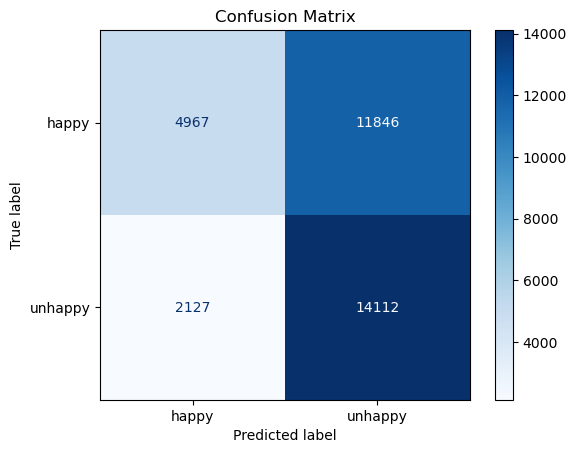

accuracy =  57.72419218201622
precision =  54.364743046459665
recall =  86.90190282652873
f1 =  66.88627153589117


In [14]:
preds = model.predict(val_pool)

preds_sad = (preds < threshold).astype(int)
y_val_sad = (y_val < threshold).astype(int)

print(np.sum(preds_sad))

cm = confusion_matrix(y_val_sad, preds_sad)

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

# Define display labels if desired
display_labels = ['happy', 'unhappy']

# Create a display object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Plot the matrix
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print('accuracy = ', str(accuracy*100))
print('precision = ', str(precision*100))
print('recall = ', str(recall*100))
print('f1 = ', str(f1*100))

In [129]:
importances = model.get_feature_importance(val_pool)
importances_loss = model.get_feature_importance(val_pool, type="LossFunctionChange")
feature_importance = sorted(zip(X_val.columns, importances), key=lambda x: -x[1])
feature_importance_loss = sorted(zip(X_val.columns, importances_loss), key=lambda x: -x[1])

print(feature_importance)
print(feature_importance_loss)

[('fincur', np.float64(26.77365644947265)), ('exerc', np.float64(20.121013080018244)), ('gpa_sr', np.float64(18.458508454973845)), ('race', np.float64(9.118681434339479)), ('gender', np.float64(9.110102523609964)), ('age', np.float64(8.167808536343182)), ('degree', np.float64(2.736502946656888)), ('residenc', np.float64(2.502291176789079)), ('international', np.float64(1.3128804070182196)), ('educ_par_max', np.float64(1.2038948024914808)), ('alc_any', np.float64(0.4946601882870211))]
[('fincur', np.float64(0.17292950361078674)), ('exerc', np.float64(0.11178397515927685)), ('gpa_sr', np.float64(0.07647198153515333)), ('gender', np.float64(0.030565909184701926)), ('age', np.float64(0.015703398880146935)), ('race', np.float64(0.012823045722292054)), ('residenc', np.float64(0.005156780843619775)), ('degree', np.float64(0.003734422224694593)), ('international', np.float64(0.0010676040118333674)), ('alc_any', np.float64(0.0002688972589393046)), ('educ_par_max', np.float64(-0.0003550855453523

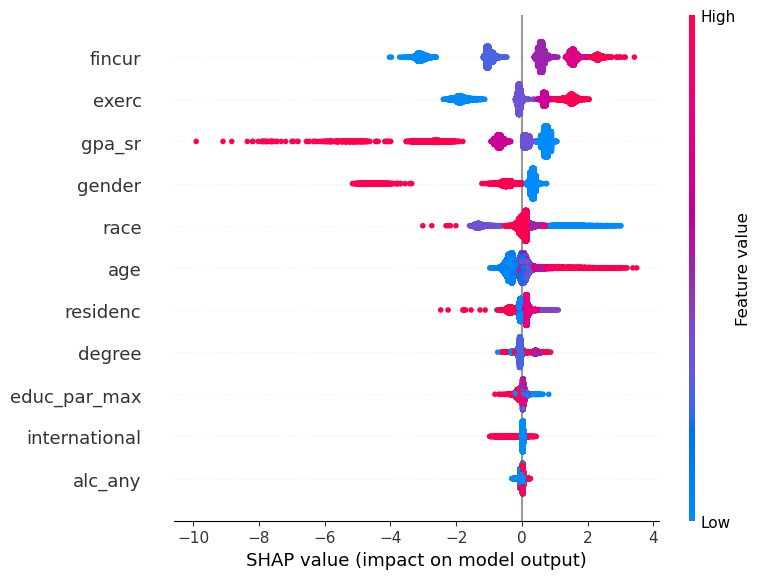

In [142]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)

In [18]:
#ranks interactions between any 2 features by importance

interaction_values = model.get_feature_importance(
    type='Interaction',
    data=Pool(X_val, cat_features=categorical_features)
)

interaction_df = pd.DataFrame(interaction_values,
    columns=['feature_idx_1', 'feature_idx_2', 'importance'])

# Map indices to column names
interaction_df['feature_1'] = interaction_df['feature_idx_1'].astype(int).map(lambda i: X_val.columns[i])
interaction_df['feature_2'] = interaction_df['feature_idx_2'].astype(int).map(lambda i: X_val.columns[i])

# Sort by importance
interaction_df = interaction_df.sort_values('importance', ascending=False)

interaction_df.head(45)

,feature_idx_1,feature_idx_2,importance,feature_1,feature_2
0,2.0,3.0,6.149226,gender,race
1,2.0,5.0,5.840617,gender,residenc
2,3.0,5.0,5.464322,race,residenc
3,3.0,7.0,4.752567,race,degree
4,2.0,4.0,4.181980,gender,educ_par_max
5,3.0,4.0,4.179109,race,educ_par_max
6,1.0,2.0,3.528701,age,gender
7,1.0,7.0,3.156899,age,degree
8,4.0,5.0,2.952837,educ_par_max,residenc
9,1.0,3.0,2.951405,age,race


In [143]:
# Create a copy so we can join SHAP values
df_shap = X_val.copy().reset_index(drop=True)

# Add the SHAP value for the 'race' feature
race_shap_idx = X_val.columns.get_loc('race')
df_shap['race_shap'] = shap_values[:, race_shap_idx]

gender_shap_idx = X_val.columns.get_loc('gender')
df_shap['gender_shap'] = shap_values[:, gender_shap_idx]

fincur_shap_idx = X_val.columns.get_loc('fincur')
df_shap['fincur_shap'] = shap_values[:, fincur_shap_idx]

exerc_shap_idx = X_val.columns.get_loc('exerc')
df_shap['exerc_shap'] = shap_values[:, exerc_shap_idx]

gpa_sr_shap_idx = X_val.columns.get_loc('gpa_sr')
df_shap['gpa_sr_shap'] = shap_values[:, gpa_sr_shap_idx]

educ_par_max_shap_idx = X_val.columns.get_loc('educ_par_max')
df_shap['educ_par_max_shap'] = shap_values[:, educ_par_max_shap_idx]

age_shap_idx = X_val.columns.get_loc('age')
df_shap['age_shap'] = shap_values[:, age_shap_idx]

# Optional: replace numeric codes with labels for clarity
race_labels = {
    1: "Black/African American (2270)",
    2: "Indigenous/Native (121)",
    3: "Asian/Asian American (3951)",
    4: "Hispanic/Latine (3484)",
    5: "Pacific Islander (51)",
    6: "Middle Eastern/Arab (433)",
    7: "White (22742)"
}
gender_labels = {
    1: "Female (22806)",
    2: "Male (9725)",
    3: "Trans (93)",
    4: "Nonbinary (428)"
}

fincur_labels = {
    1: "Always stressful (4698)",
    2: "Often stressful (7929)",
    3: "Sometimes stressful (11749)",
    4: "Rarely stressful (6527)",
    5: "Never stressful (2149)"
}

gpa_sr_labels = {
2: 'Mostly As (17018)',
3: 'Mostly As and Bs (6388)',
4: 'Mostly Bs (6641)',
5: 'Mostly Bs and Cs (1495)',
6: 'Mostly Cs (1261)',
7: 'Mostly Cs and Ds (123)',
8: 'Mostly Ds (89)',
9: 'Mostly Ds and Fs (15)',
10: 'Mostly Fs (22)'
}

exerc_labels = {
1: 'Less than 1 hour (8697)',
2: '1-3 hours (10655)',
3: '3-4 hours (5138)',
4: '5 or more hours (8562)'
}

educ_par_max_labels = {
1: '8th grade or lower (715)',
2: 'Between 9th and 12th grade (809)',
3: 'High school degree (3460)',
4: 'Some college (but no college degree) (3759)',
5: 'Associate’s degree (2721)',
6: 'Bachelor’s degree (10299)',
7: 'Graduate degree (11289)'
}

age_labels = {
18: '18-20 (14548)',
19: '18-20 (14548)',
20: '18-20 (14548)',
21: '21-25 (11902)',
22: '21-25 (11902)',
23: '21-25 (11902)',
24: '21-25 (11902)',
25: '21-25 (11902)',
26: '26-30 (3217)',
27: '26-30 (3217)',
28: '26-30 (3217)',
29: '26-30 (3217)',
30: '26-30 (3217)',
31: '31-35 (1474)',
32: '31-35 (1474)',
33: '31-35 (1474)',
34: '31-35 (1474)',
35: '31-35 (1474)',
36: '36-40 (753)',
37: '36-40 (753)',
38: '36-40 (753)',
39: '36-40 (753)',
40: '36-40 (753)',
41: '41-45 (516)',
42: '41-45 (516)',
43: '41-45 (516)',
44: '41-45 (516)',
45: '41-45 (516)',
46: '46-50 (339)',
47: '46-50 (339)',
48: '46-50 (339)',
49: '46-50 (339)',
50: '46-50 (339)',
51: '51-55 (205)',
52: '51-55 (205)',
53: '51-55 (205)',
54: '51-55 (205)',
55: '51-55 (205)',
56: '56-60 (98)',
57: '56-60 (98)',
58: '56-60 (98)',
59: '56-60 (98)',
60: '56-60 (98)'
}

fincur_order = list(fincur_labels.values())
gpa_sr_order = list(gpa_sr_labels.values())
exerc_order = list(exerc_labels.values())
educ_par_max_order = list(educ_par_max_labels.values())
age_list = list(age_labels.values())
age_order = list(dict.fromkeys(age_list))

df_shap['race_label'] = df_shap['race'].map(race_labels)
df_shap['gender_label'] = df_shap['gender'].map(gender_labels)
df_shap['fincur_label'] = df_shap['fincur'].map(fincur_labels)
df_shap['gpa_sr_label'] = df_shap['gpa_sr'].map(gpa_sr_labels)
df_shap['exerc_label'] = df_shap['exerc'].map(exerc_labels)
df_shap['educ_par_max_label'] = df_shap['educ_par_max'].map(educ_par_max_labels)
df_shap['age_label'] = df_shap['age'].map(age_labels)

df_shap['gpa_sr_label'] = pd.Categorical(
    df_shap['gpa_sr_label'],
    categories=gpa_sr_order,
    ordered=True
)

df_shap['fincur_label'] = pd.Categorical(
    df_shap['fincur_label'],
    categories=fincur_order,
    ordered=True
)

df_shap['exerc_label'] = pd.Categorical(
    df_shap['exerc_label'],
    categories=exerc_order,
    ordered=True
)

df_shap['educ_par_max_label'] = pd.Categorical(
    df_shap['educ_par_max_label'],
    categories=educ_par_max_order,
    ordered=True
)

df_shap['age_label'] = pd.Categorical(
    df_shap['age_label'],
    categories=age_order,
    ordered=True
)

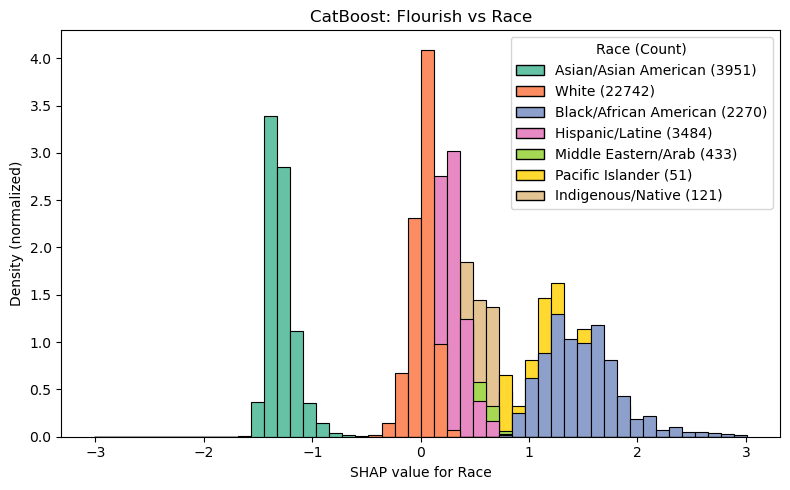

In [144]:
ax = plt.figure(figsize=(8, 5))
ax = sns.histplot(
    data=df_shap,
    x='race_shap',
    hue='race_label',
    bins=50,
    multiple='layer',    # overlay
    stat='density',      # <-- normalize within each race
    common_norm=False,   # <-- normalize per hue, not globally
    alpha=1,
    palette='Set2'
)
sns.move_legend(ax, "upper right", title="Race (Count)")
plt.xlabel("SHAP value for Race")
plt.ylabel("Density (normalized)")
plt.title("CatBoost: Flourish vs Race")
plt.tight_layout()
plt.show()

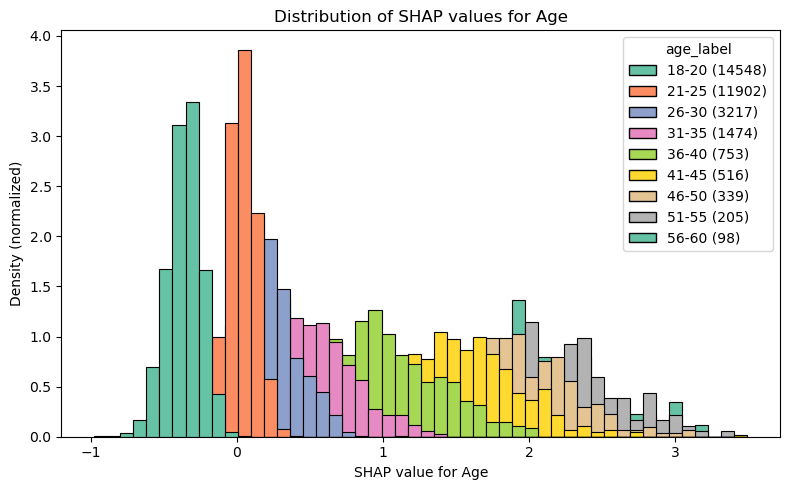

In [49]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_shap,
    x='age_shap',
    hue='age_label',
    bins=50,
    multiple='layer',    # overlay
    stat='density',      # <-- normalize within each race
    common_norm=False,   # <-- normalize per hue, not globally
    alpha=1,
    palette='Set2'
)
plt.xlabel("SHAP value for Age")
plt.ylabel("Density (normalized)")
plt.title("Distribution of SHAP values for Age")
plt.tight_layout()
plt.show()

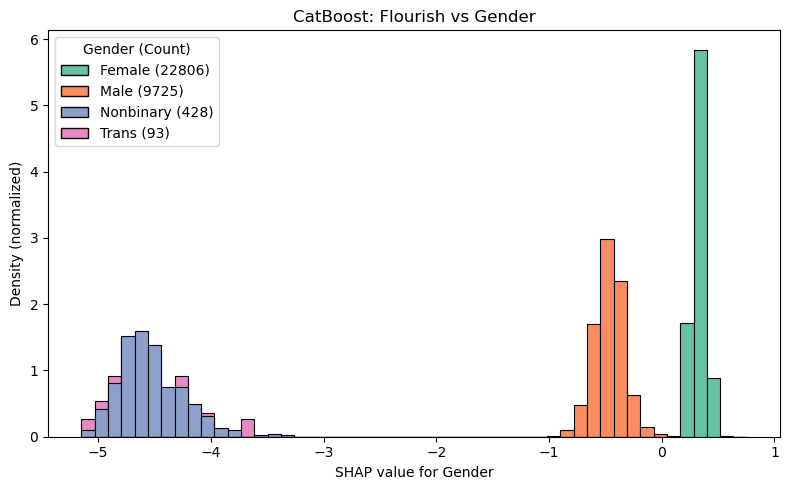

In [145]:
plt.figure(figsize=(8, 5))
ax = sns.histplot(
    data=df_shap,
    x='gender_shap',
    hue='gender_label',
    bins=50,
    multiple='layer',    # overlay
    stat='density',      # <-- normalize within each race
    common_norm=False,   # <-- normalize per hue, not globally
    alpha=1,
    palette='Set2',
)
sns.move_legend(ax, "upper left", title="Gender (Count)")
plt.xlabel("SHAP value for Gender")
plt.ylabel("Density (normalized)")
plt.title("CatBoost: Flourish vs Gender")
plt.tight_layout()
plt.show()

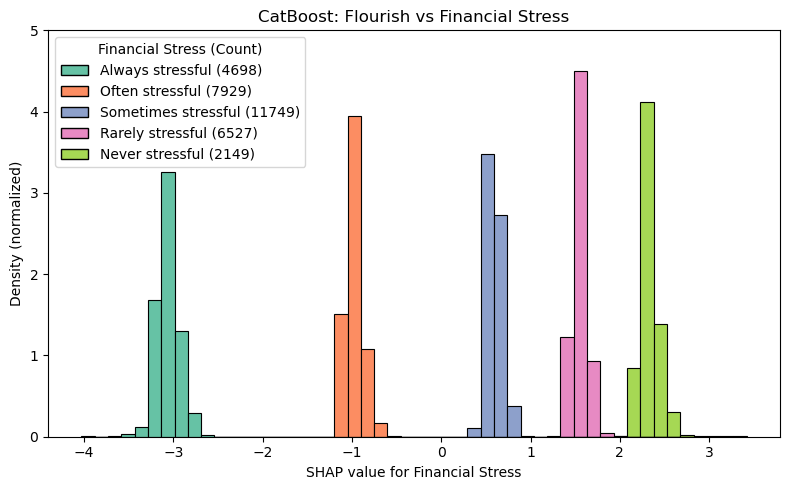

In [146]:
plt.figure(figsize=(8, 5))
ax = sns.histplot(
    data=df_shap,
    x='fincur_shap',
    hue='fincur_label',
    bins=50,
    multiple='layer',    # overlay
    stat='density',      # <-- normalize within each race
    common_norm=False,   # <-- normalize per hue, not globally
    alpha=1,
    palette='Set2',
    hue_order=df_shap['fincur_label'].cat.categories
)
sns.move_legend(ax, "upper left", title="Financial Stress (Count)")
plt.xlabel("SHAP value for Financial Stress")
plt.ylabel("Density (normalized)")
plt.title("CatBoost: Flourish vs Financial Stress")
plt.ylim(0,5)
plt.tight_layout()
plt.show()

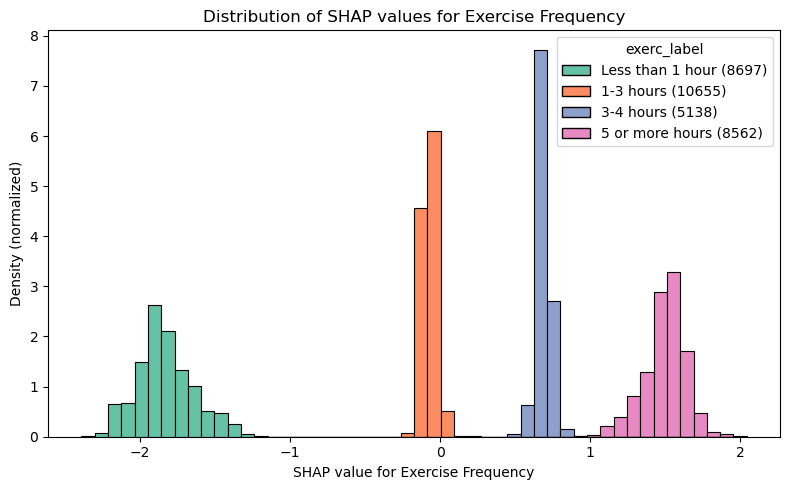

In [48]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_shap,
    x='exerc_shap',
    hue='exerc_label',
    bins=50,
    multiple='layer',    # overlay
    stat='density',      # <-- normalize within each race
    common_norm=False,   # <-- normalize per hue, not globally
    alpha=1,
    palette='Set2',
    hue_order=df_shap['exerc_label'].cat.categories
)
plt.xlabel("SHAP value for Exercise Frequency")
plt.ylabel("Density (normalized)")
plt.title("Distribution of SHAP values for Exercise Frequency")
plt.tight_layout()
plt.show()

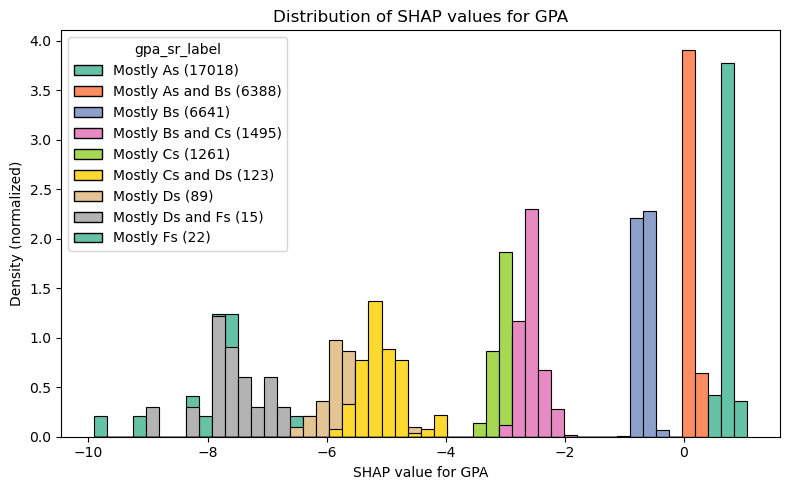

In [52]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_shap,
    x='gpa_sr_shap',
    hue='gpa_sr_label',
    bins=50,
    multiple='layer',    # overlay
    stat='density',      # <-- normalize within each race
    common_norm=False,   # <-- normalize per hue, not globally
    alpha=1,
    palette='Set2',
    hue_order=df_shap['gpa_sr_label'].cat.categories
)
plt.xlabel("SHAP value for GPA")
plt.ylabel("Density (normalized)")
plt.title("Distribution of SHAP values for GPA")
plt.tight_layout()
plt.show()

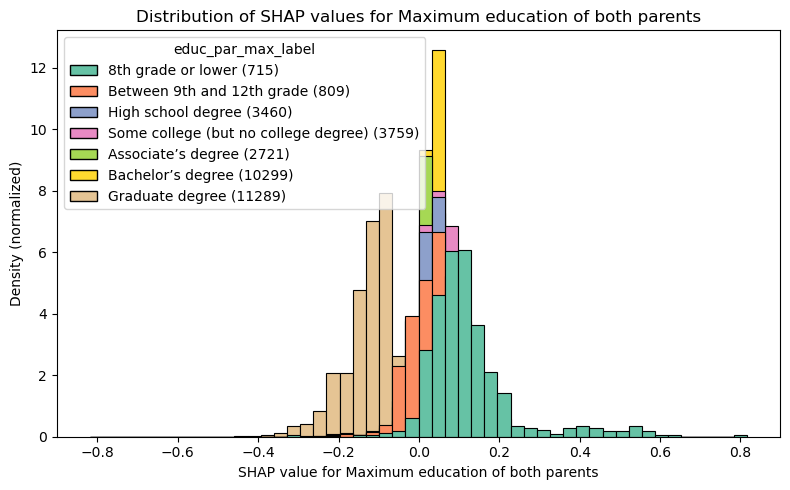

In [55]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_shap,
    x='educ_par_max_shap',
    hue='educ_par_max_label',
    bins=50,
    multiple='layer',    # overlay
    stat='density',      # <-- normalize within each race
    common_norm=False,   # <-- normalize per hue, not globally
    alpha=1,
    palette='Set2',
    hue_order=df_shap['educ_par_max_label'].cat.categories
)
plt.xlabel("SHAP value for Maximum education of both parents")
plt.ylabel("Density (normalized)")
plt.title("Distribution of SHAP values for Maximum education of both parents")
plt.tight_layout()
plt.show()

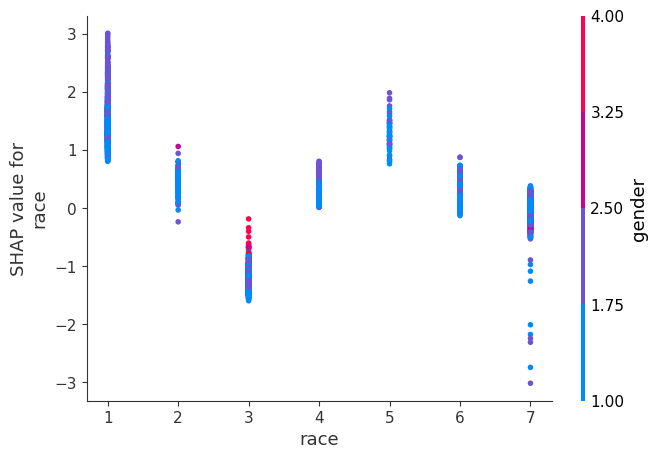

In [56]:
shap.dependence_plot(
    'race',
    shap_values,
    X_val,
    interaction_index='gender'
)

#Race:
#1 = African American/Black
#2 = American Indian or Alaskan Native
#3 = Asian American/Asian
#4 = Hispanic/Latine
#5 = Native Hawaiian or Pacific Islander
#6 = Middle Eastern, Arab, or Arab American
#7 = White

#Gender:
#1 = female 
#2 = male 
#3 = trans 
#4 = non binary

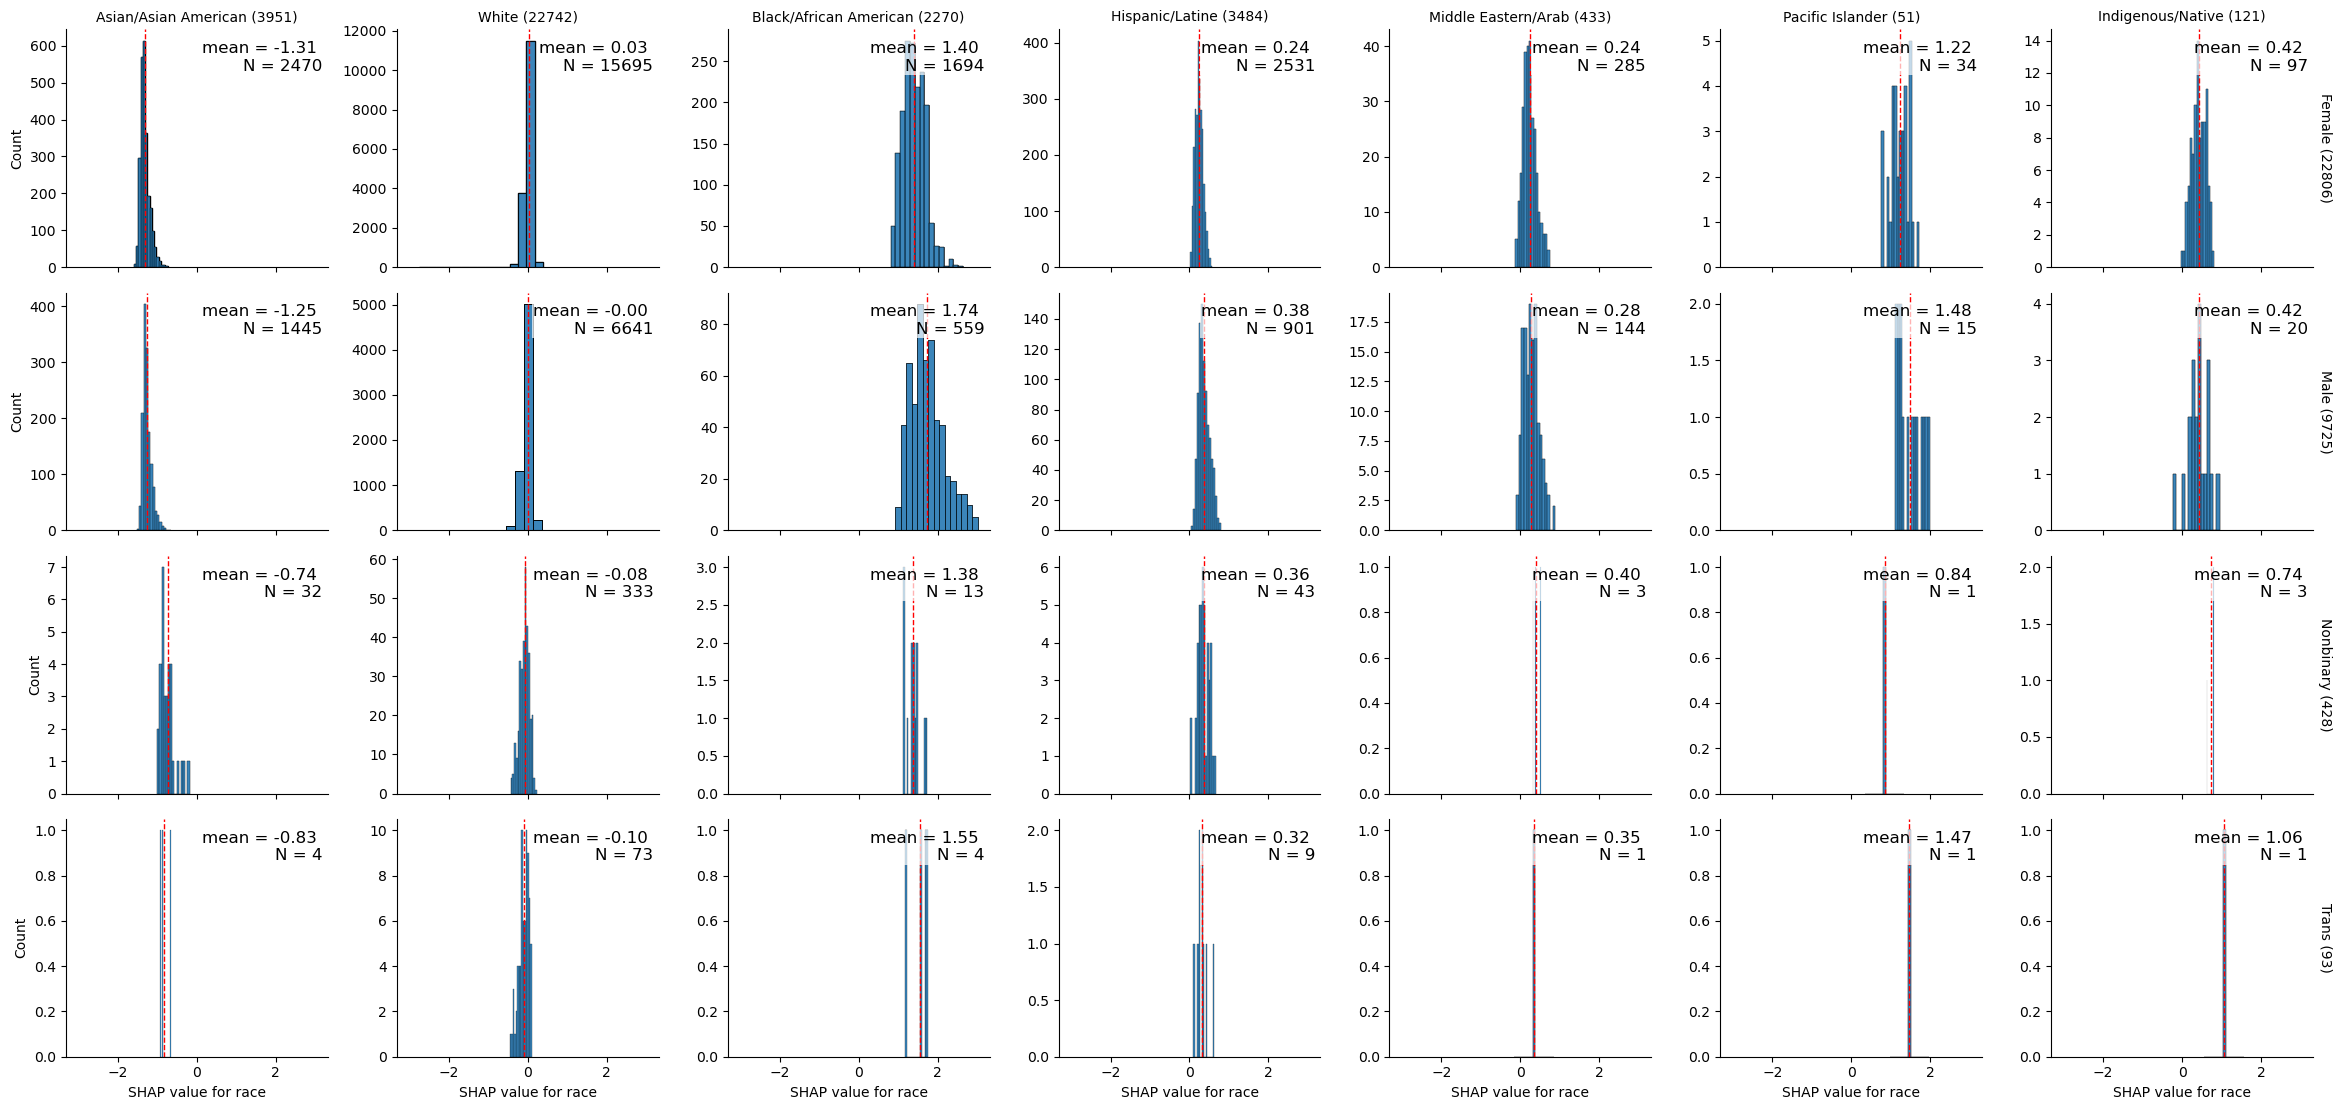

In [127]:
def hist_with_mean(data, color, **kwargs):
    ax = sns.histplot(data=data, x='race_shap', bins=15, color=color, alpha=0.7)
    mean_val = data['race_shap'].mean()
    count_val = len(data)
    # Vertical line
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=1)
    # Annotation at top right
    ymax = ax.get_ylim()[1]
    ax.text(
        0.98, 0.95, f"mean = {mean_val:.2f} \nN = {count_val}",
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=12, color='black',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
    )

# Create grid: rows = gender, cols = race
g = sns.FacetGrid(
    df_shap,
    row='gender_label',
    col='race_label',
    margin_titles=True,
    sharex=True,
    sharey=False,
    height=2.8,
    aspect=1.2
)

g.map_dataframe(sns.histplot, x='race_shap', bins=15, color='steelblue', alpha=0.7)
g.map_dataframe(hist_with_mean)
g.set_axis_labels("SHAP value for race", "Count")
g.set_titles(row_template='{row_name}', col_template='{col_name}')
plt.tight_layout()
plt.show()

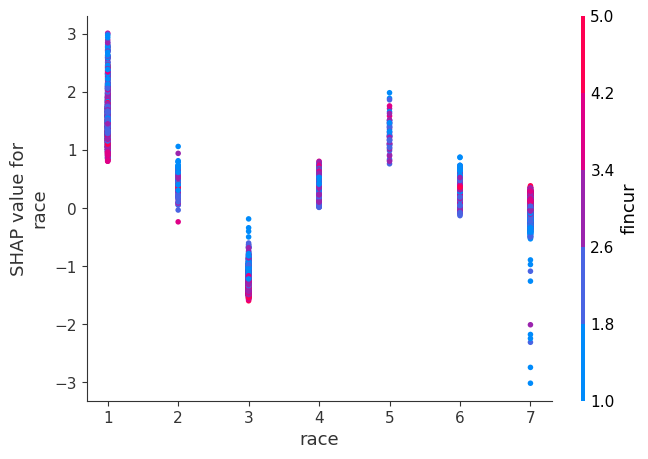

In [58]:
shap.dependence_plot(
    'race',
    shap_values,
    X_val,
    interaction_index='fincur'
)

#Race:
#1 = African American/Black
#2 = American Indian or Alaskan Native
#3 = Asian American/Asian
#4 = Hispanic/Latine
#5 = Native Hawaiian or Pacific Islander
#6 = Middle Eastern, Arab, or Arab American
#7 = White

#Fincur:
#1 = most stressed
#5 = least stressed

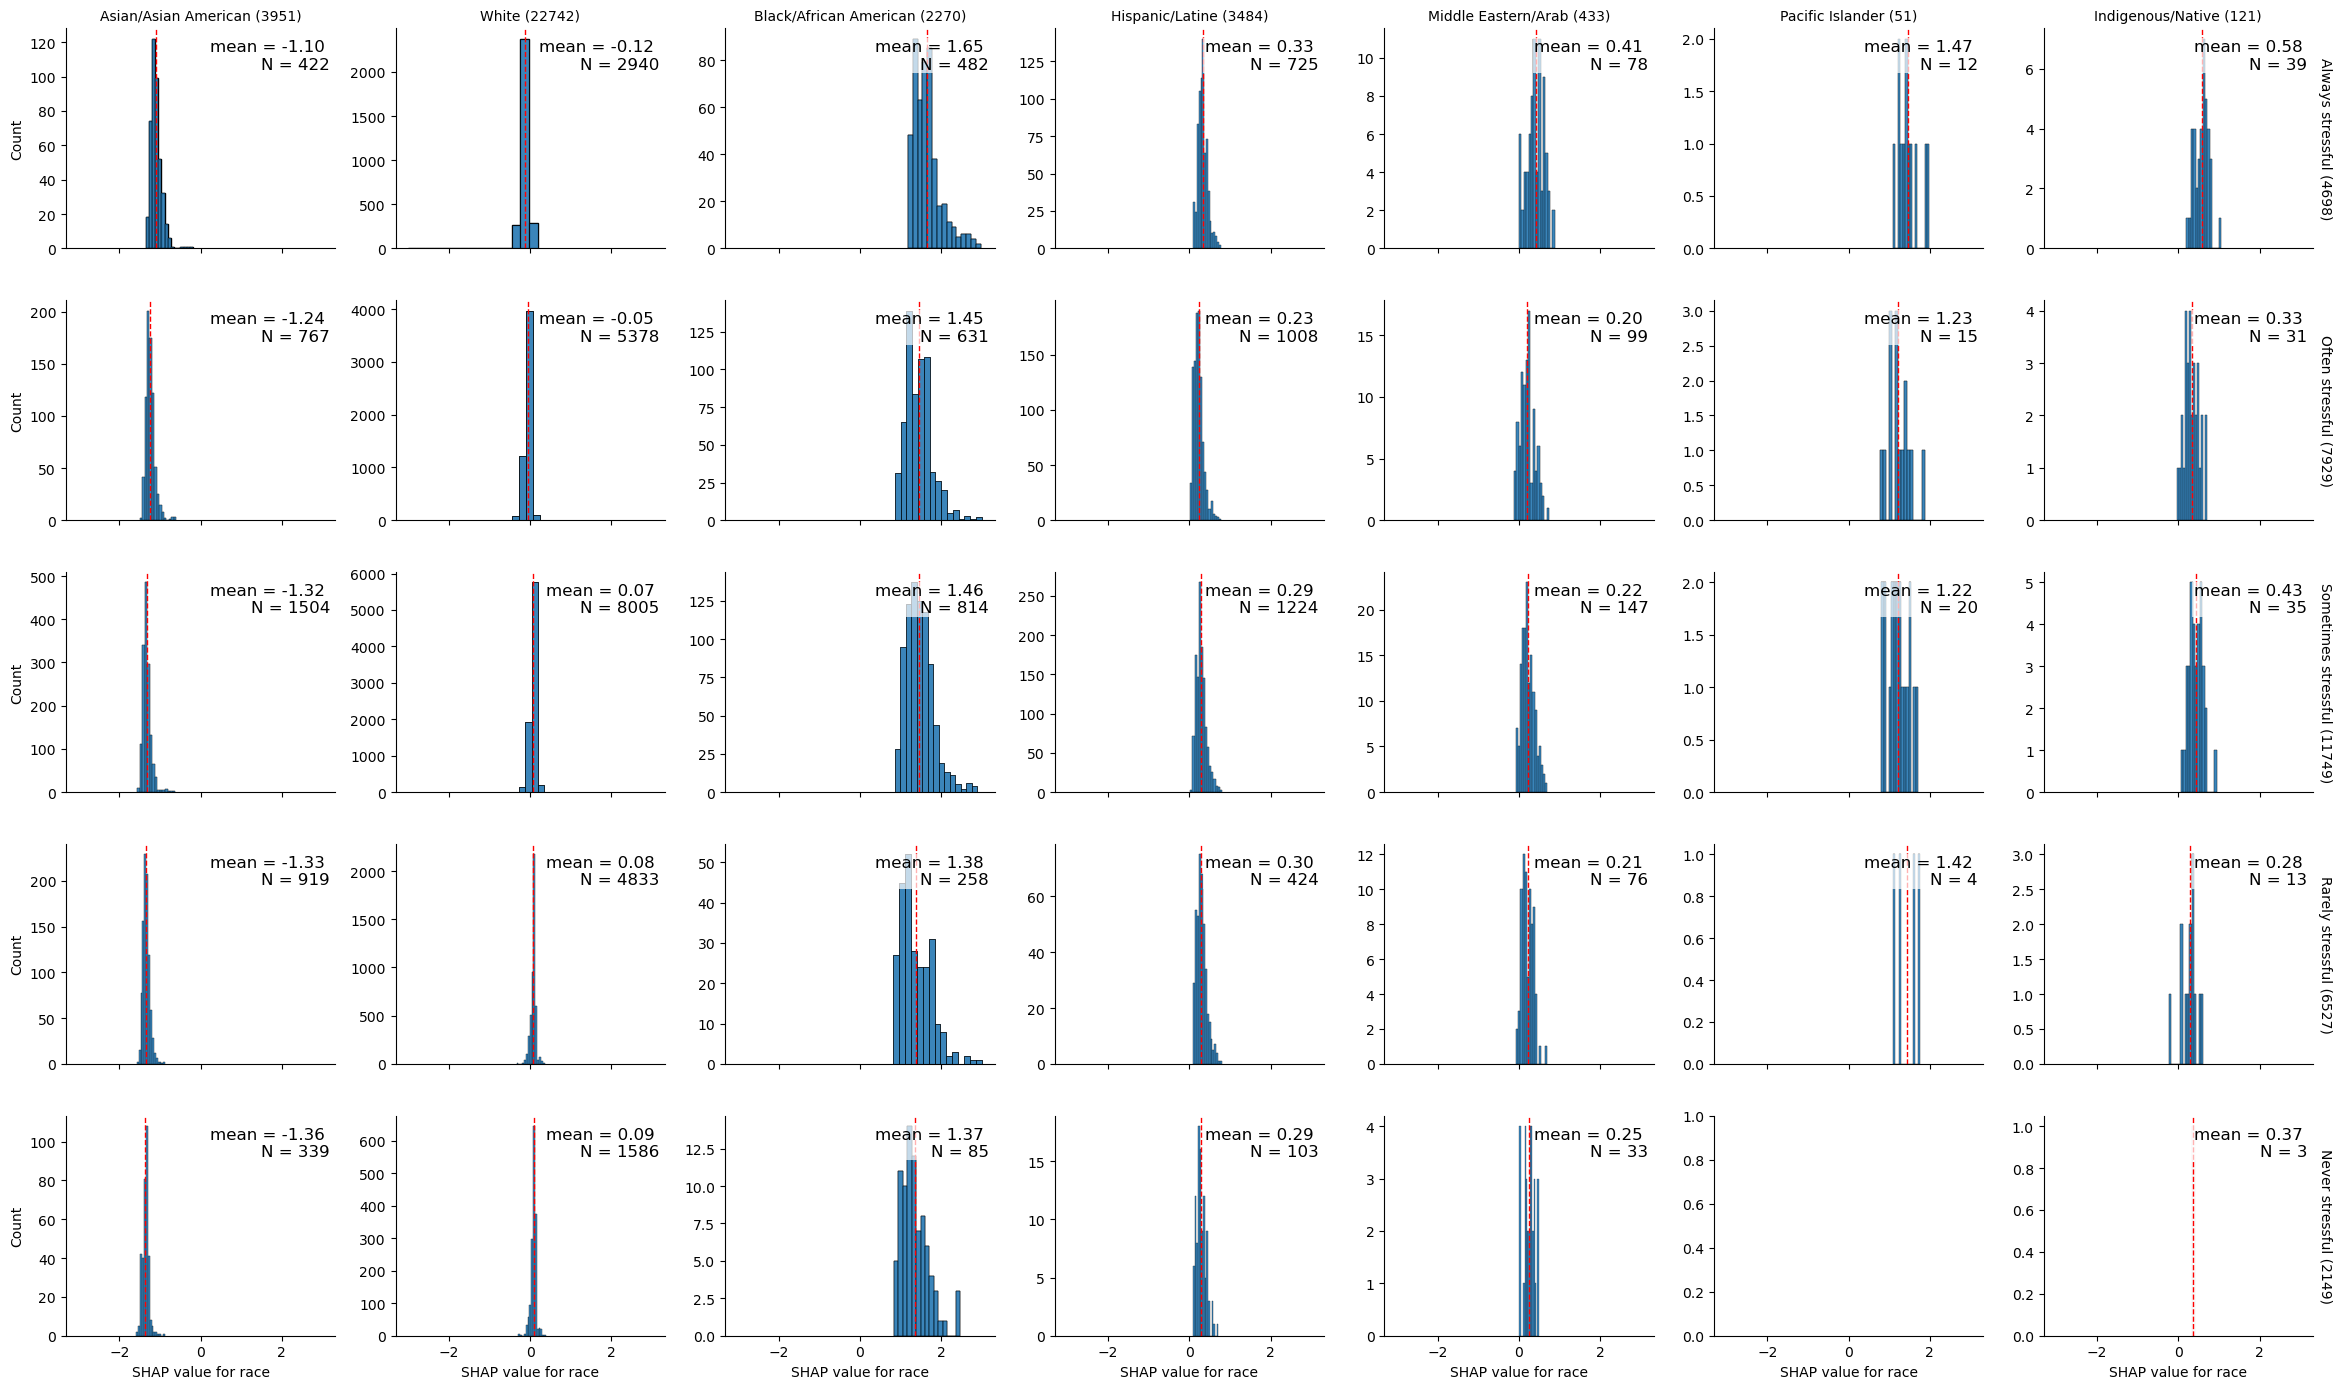

In [128]:
# Create grid: rows = gender, cols = race
g = sns.FacetGrid(
    df_shap,
    row='fincur_label',
    col='race_label',
    row_order=fincur_order,
    margin_titles=True,
    sharex=True,
    sharey=False,
    height=2.8,
    aspect=1.2
)

g.map_dataframe(sns.histplot, x='race_shap', bins=15, color='steelblue', alpha=0.7)
g.map_dataframe(hist_with_mean)
g.set_axis_labels("SHAP value for race", "Count")
g.set_titles(row_template='{row_name}', col_template='{col_name}')
plt.tight_layout()
plt.show()

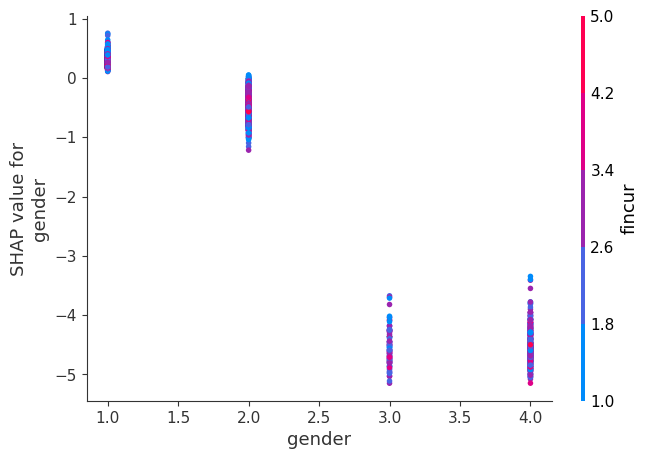

In [60]:
shap.dependence_plot(
    'gender',
    shap_values,
    X_val,
    interaction_index='fincur'
)

#Gender:
#1 = female 
#2 = male 
#3 = trans 
#4 = non binary

#Fincur:
#1 = most stressed
#5 = least stressed

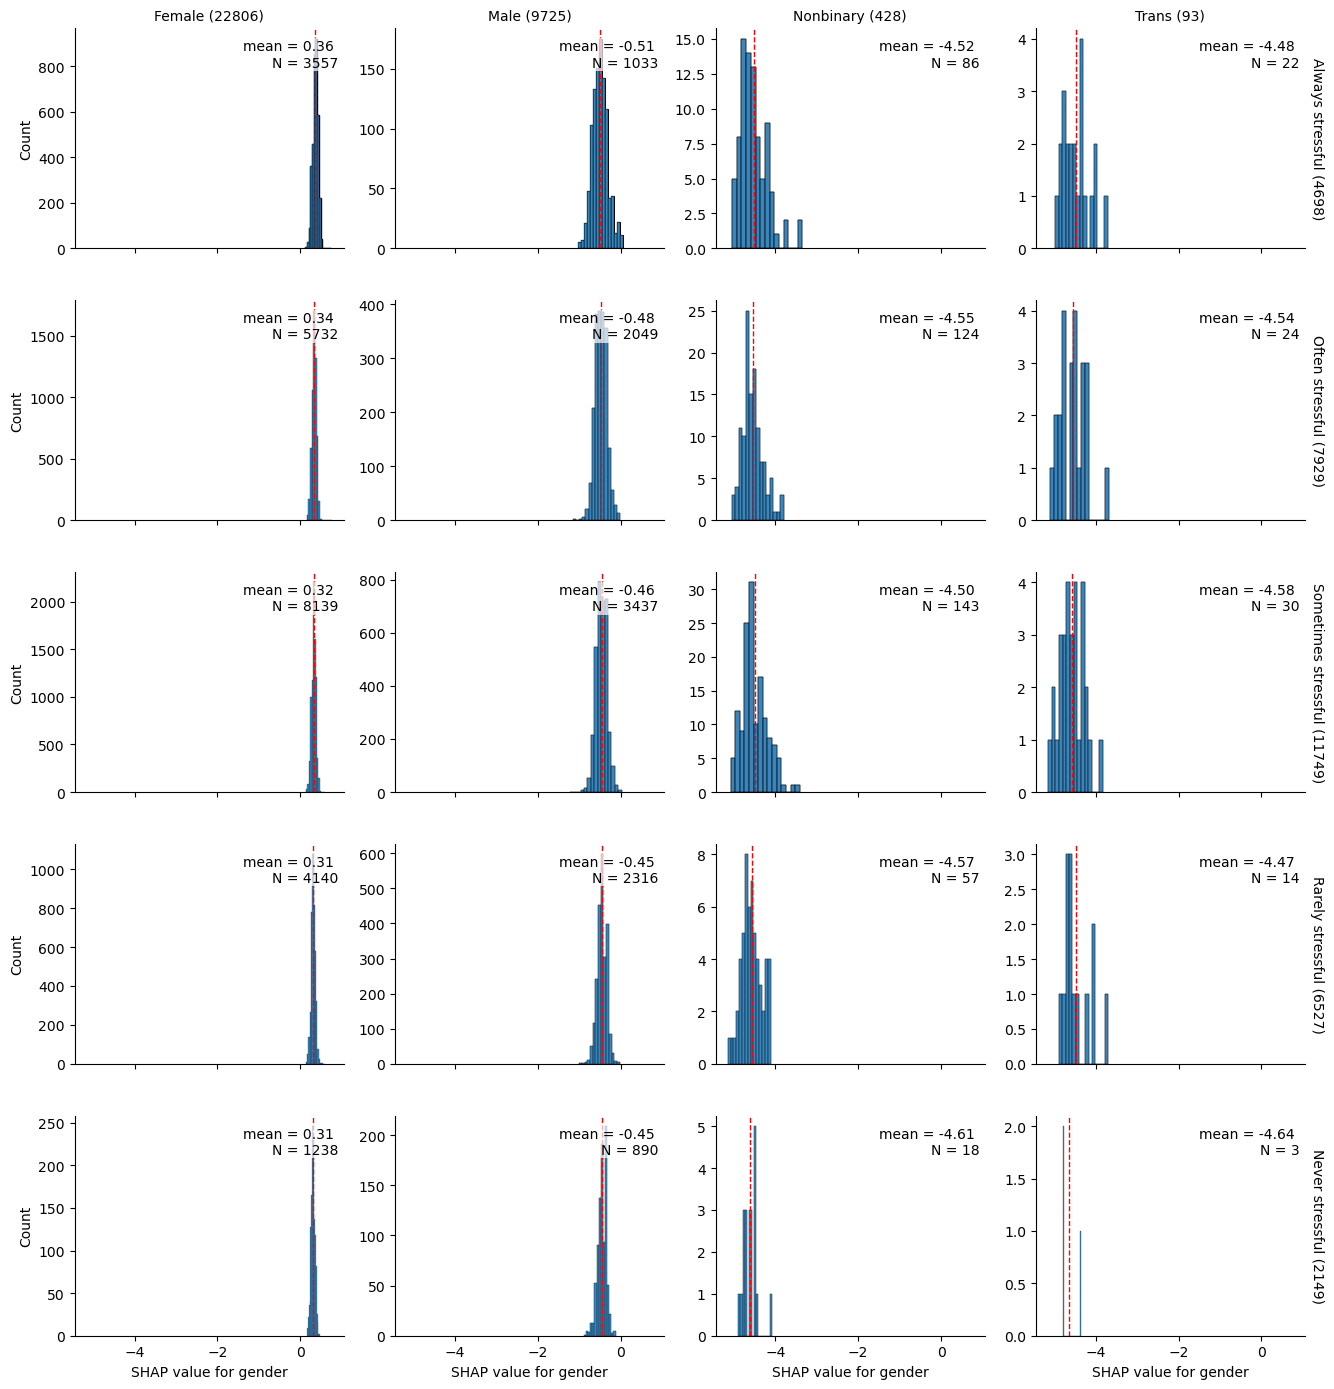

In [61]:
def hist_with_mean_gender(data, color, **kwargs):
    ax = sns.histplot(data=data, x='gender_shap', bins=15, color=color, alpha=0.7)
    mean_val = data['gender_shap'].mean()
    count_val = len(data)
    # Vertical line
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=1)
    # Annotation at top right
    ymax = ax.get_ylim()[1]
    ax.text(
        0.98, 0.95, f"mean = {mean_val:.2f} \nN = {count_val}",
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=10, color='black',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
    )

# Create grid: rows = gender, cols = race
g = sns.FacetGrid(
    df_shap,
    row='fincur_label',
    col='gender_label',
    row_order=fincur_order,
    margin_titles=True,
    sharex=True,
    sharey=False,
    height=2.8,
    aspect=1.2
)

g.map_dataframe(sns.histplot, x='gender_shap', bins=15, color='steelblue', alpha=0.7)
g.map_dataframe(hist_with_mean_gender)
g.set_axis_labels("SHAP value for gender", "Count")
g.set_titles(row_template='{row_name}', col_template='{col_name}')
plt.tight_layout()
plt.show()

In [63]:
import statsmodels.formula.api as smf

df_shap['fincur_shift'] = df_shap['fincur'] - 3

model = smf.ols(
    "fincur_shap ~ fincur_shift * C(race_label, Treatment(reference='White (22742)'))",
    data=df_shap
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            fincur_shap   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                 4.900e+04
Date:                Wed, 05 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:38:53   Log-Likelihood:                -12488.
No. Observations:               33052   AIC:                         2.500e+04
Df Residuals:                   33038   BIC:                         2.512e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

### Code for Anxiety Score

In [64]:
df_clean_train = df_train[['anx_score', 'fincur','age','gender','race', 'educ_par_max', 'residenc', 'international', 'degree', 'gpa_sr', 'alc_any', 'exerc']]
df_clean_train = df_clean_train.dropna()

mask = df_clean_train['gpa_sr'] < 6
df_clean_train = df_clean_train[mask]
df_clean_train['gpa_sr'] = df_clean_train['gpa_sr']*2
df_clean_train = df_clean_train.astype('int64')

df_clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130537 entries, 0 to 90081
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   anx_score      130537 non-null  int64
 1   fincur         130537 non-null  int64
 2   age            130537 non-null  int64
 3   gender         130537 non-null  int64
 4   race           130537 non-null  int64
 5   educ_par_max   130537 non-null  int64
 6   residenc       130537 non-null  int64
 7   international  130537 non-null  int64
 8   degree         130537 non-null  int64
 9   gpa_sr         130537 non-null  int64
 10  alc_any        130537 non-null  int64
 11  exerc          130537 non-null  int64
dtypes: int64(12)
memory usage: 12.9 MB


In [65]:
df_clean_val = df_val[['anx_score', 'fincur','age','gender','race', 'educ_par_max', 'residenc', 'international', 'degree', 'gpa_sr', 'alc_any', 'exerc']]
df_clean_val = df_clean_val.dropna()

mask = df_clean_val['gpa_sr'] < 6
df_clean_val = df_clean_val[mask]
df_clean_val['gpa_sr'] = df_clean_val['gpa_sr']*2
df_clean_val = df_clean_val.astype('int64')

df_clean_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32821 entries, 3 to 60055
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   anx_score      32821 non-null  int64
 1   fincur         32821 non-null  int64
 2   age            32821 non-null  int64
 3   gender         32821 non-null  int64
 4   race           32821 non-null  int64
 5   educ_par_max   32821 non-null  int64
 6   residenc       32821 non-null  int64
 7   international  32821 non-null  int64
 8   degree         32821 non-null  int64
 9   gpa_sr         32821 non-null  int64
 10  alc_any        32821 non-null  int64
 11  exerc          32821 non-null  int64
dtypes: int64(12)
memory usage: 3.3 MB


In [66]:
X_train = df_clean_train[['fincur','age','gender','race', 'educ_par_max', 'residenc', 'international', 'degree', 'gpa_sr', 'alc_any', 'exerc']]
y_train = df_clean_train['anx_score']

X_val = df_clean_val[['fincur','age','gender','race', 'educ_par_max', 'residenc', 'international', 'degree', 'gpa_sr', 'alc_any', 'exerc']]
y_val = df_clean_val['anx_score']

In [67]:
# Define categorical feature names or indices
categorical_features = ['gender', 'race', 'educ_par_max', 'residenc', 'international', 'degree', 'alc_any']

# Create CatBoost Pool
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
val_pool  = Pool(data=X_val,  label=y_val,  cat_features=categorical_features)

In [68]:
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03406591545597747,
    depth=5,
    bagging_temperature=0.9981270281186665,
    l2_leaf_reg=4.587147851024917,
    min_data_in_leaf=47,
    random_strength=0.1655604323092239,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=22,
    verbose=100
)

model.fit(train_pool, eval_set=val_pool)

0:	learn: 5.7039652	test: 5.7104780	best: 5.7104780 (0)	total: 46.8ms	remaining: 46.8s
100:	learn: 5.2604170	test: 5.2450193	best: 5.2450193 (100)	total: 2.06s	remaining: 18.3s
200:	learn: 5.2405200	test: 5.2245547	best: 5.2245547 (200)	total: 4.33s	remaining: 17.2s
300:	learn: 5.2344997	test: 5.2200504	best: 5.2200504 (300)	total: 5.9s	remaining: 13.7s
400:	learn: 5.2317879	test: 5.2188137	best: 5.2188137 (400)	total: 7.41s	remaining: 11.1s
500:	learn: 5.2296991	test: 5.2180264	best: 5.2180264 (500)	total: 8.89s	remaining: 8.85s
600:	learn: 5.2278954	test: 5.2175288	best: 5.2175288 (600)	total: 10.3s	remaining: 6.83s
700:	learn: 5.2264350	test: 5.2172458	best: 5.2172449 (699)	total: 11.6s	remaining: 4.93s
800:	learn: 5.2249738	test: 5.2169099	best: 5.2169099 (800)	total: 13.1s	remaining: 3.26s
900:	learn: 5.2235022	test: 5.2166319	best: 5.2166319 (900)	total: 14.6s	remaining: 1.61s
999:	learn: 5.2221489	test: 5.2163909	best: 5.2163870 (985)	total: 16s	remaining: 0us

bestTest = 5.2163

In [69]:
print('MSE = ', str(5.216386966**2))

r2_catboost = model.score(X_val, y_val)

print('r2 (catboost) = ', r2_catboost)

MSE =  27.210692979054684
r2 (catboost) =  0.17323165198268786


In [70]:
threshold = y_val.median()
print(threshold)

6.0


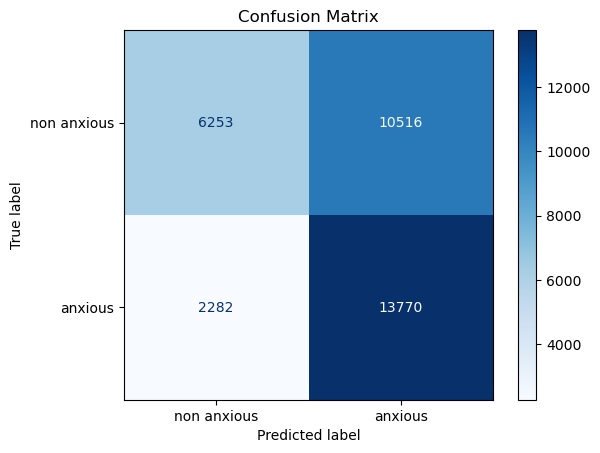

accuracy =  61.00667255720423
precision =  56.699332949024125
recall =  85.78370296536258
f1 =  68.27309236947791


In [73]:
preds = model.predict(val_pool)

preds_anx = (preds > threshold).astype(int)
y_val_anx = (y_val > threshold).astype(int)

cm = confusion_matrix(y_val_anx, preds_anx)

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

# Define display labels if desired
display_labels = ['non anxious', 'anxious']

# Create a display object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Plot the matrix
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print('accuracy = ', str(accuracy*100))
print('precision = ', str(precision*100))
print('recall = ', str(recall*100))
print('f1 = ', str(f1*100))

In [74]:
importances = model.get_feature_importance(val_pool)
feature_importance = sorted(zip(X_val.columns, importances), key=lambda x: -x[1])

print(feature_importance)

[('fincur', np.float64(40.6997492311457)), ('gender', np.float64(21.911156928644512)), ('age', np.float64(10.64806946482197)), ('exerc', np.float64(7.5716122689324825)), ('race', np.float64(6.956902726126746)), ('gpa_sr', np.float64(5.506901530671957)), ('alc_any', np.float64(2.663081987768583)), ('residenc', np.float64(1.3757040484810592)), ('educ_par_max', np.float64(1.2523129269429896)), ('degree', np.float64(1.1678973149043306)), ('international', np.float64(0.24661157155971625))]


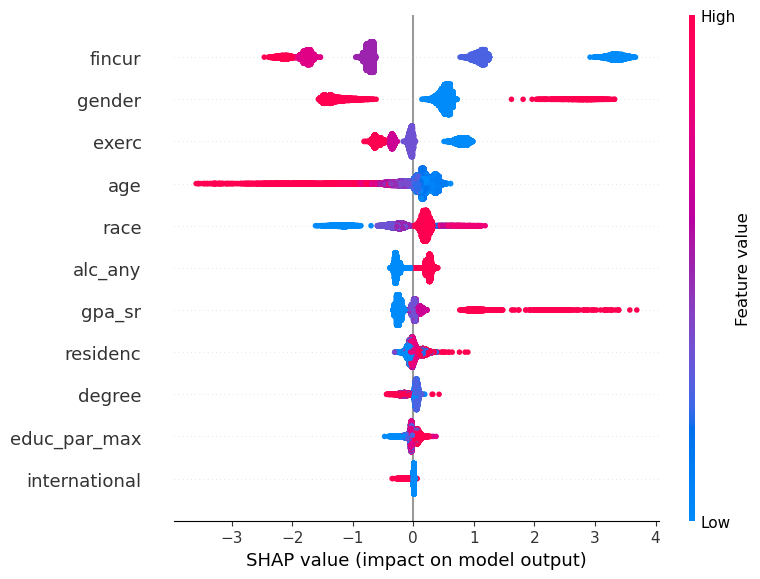

In [75]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)

In [76]:
#ranks interactions between any 2 features by importance

interaction_values = model.get_feature_importance(
    type='Interaction',
    data=Pool(X_val, cat_features=categorical_features)
)

interaction_df = pd.DataFrame(interaction_values,
    columns=['feature_idx_1', 'feature_idx_2', 'importance'])

# Map indices to column names
interaction_df['feature_1'] = interaction_df['feature_idx_1'].astype(int).map(lambda i: X_val.columns[i])
interaction_df['feature_2'] = interaction_df['feature_idx_2'].astype(int).map(lambda i: X_val.columns[i])

# Sort by importance
interaction_df = interaction_df.sort_values('importance', ascending=False)

interaction_df.head(45)

,feature_idx_1,feature_idx_2,importance,feature_1,feature_2
0,2.0,4.0,6.162031,gender,educ_par_max
1,2.0,5.0,5.112525,gender,residenc
2,3.0,5.0,4.962748,race,residenc
3,3.0,4.0,4.849733,race,educ_par_max
4,2.0,3.0,4.604761,gender,race
5,3.0,7.0,4.265352,race,degree
6,2.0,7.0,4.227051,gender,degree
7,4.0,5.0,3.915522,educ_par_max,residenc
8,1.0,5.0,3.491692,age,residenc
9,1.0,3.0,3.240213,age,race


In [77]:
# Create a copy so we can join SHAP values
df_shap = X_val.copy().reset_index(drop=True)

# Add the SHAP value for the 'race' feature
race_shap_idx = X_val.columns.get_loc('race')
df_shap['race_shap'] = shap_values[:, race_shap_idx]

gender_shap_idx = X_val.columns.get_loc('gender')
df_shap['gender_shap'] = shap_values[:, gender_shap_idx]

fincur_shap_idx = X_val.columns.get_loc('fincur')
df_shap['fincur_shap'] = shap_values[:, fincur_shap_idx]

exerc_shap_idx = X_val.columns.get_loc('exerc')
df_shap['exerc_shap'] = shap_values[:, exerc_shap_idx]

gpa_sr_shap_idx = X_val.columns.get_loc('gpa_sr')
df_shap['gpa_sr_shap'] = shap_values[:, gpa_sr_shap_idx]

educ_par_max_shap_idx = X_val.columns.get_loc('educ_par_max')
df_shap['educ_par_max_shap'] = shap_values[:, educ_par_max_shap_idx]

age_shap_idx = X_val.columns.get_loc('age')
df_shap['age_shap'] = shap_values[:, age_shap_idx]

# Optional: replace numeric codes with labels for clarity
race_labels = {
    1: "Black/African American (2270)",
    2: "Indigenous/Native (121)",
    3: "Asian/Asian American (3951)",
    4: "Hispanic/Latine (3484)",
    5: "Pacific Islander (51)",
    6: "Middle Eastern/Arab (433)",
    7: "White (22742)"
}
gender_labels = {
    1: "Female (22806)",
    2: "Male (9725)",
    3: "Trans (93)",
    4: "Nonbinary (428)"
}

fincur_labels = {
    1: "Always stressful (4698)",
    2: "Often stressful (7929)",
    3: "Sometimes stressful (11749)",
    4: "Rarely stressful (6527)",
    5: "Never stressful (2149)"
}

gpa_sr_labels = {
2: 'Mostly As (17018)',
3: 'Mostly As and Bs (6388)',
4: 'Mostly Bs (6641)',
5: 'Mostly Bs and Cs (1495)',
6: 'Mostly Cs (1261)',
7: 'Mostly Cs and Ds (123)',
8: 'Mostly Ds (89)',
9: 'Mostly Ds and Fs (15)',
10: 'Mostly Fs (22)'
}

exerc_labels = {
1: 'Less than 1 hour (8697)',
2: '1-3 hours (10655)',
3: '3-4 hours (5138)',
4: '5 or more hours (8562)'
}

educ_par_max_labels = {
1: '8th grade or lower (715)',
2: 'Between 9th and 12th grade (809)',
3: 'High school degree (3460)',
4: 'Some college (but no college degree) (3759)',
5: 'Associate’s degree (2721)',
6: 'Bachelor’s degree (10299)',
7: 'Graduate degree (11289)'
}

age_labels = {
18: '18-20 (14548)',
19: '18-20 (14548)',
20: '18-20 (14548)',
21: '21-25 (11902)',
22: '21-25 (11902)',
23: '21-25 (11902)',
24: '21-25 (11902)',
25: '21-25 (11902)',
26: '26-30 (3217)',
27: '26-30 (3217)',
28: '26-30 (3217)',
29: '26-30 (3217)',
30: '26-30 (3217)',
31: '31-35 (1474)',
32: '31-35 (1474)',
33: '31-35 (1474)',
34: '31-35 (1474)',
35: '31-35 (1474)',
36: '36-40 (753)',
37: '36-40 (753)',
38: '36-40 (753)',
39: '36-40 (753)',
40: '36-40 (753)',
41: '41-45 (516)',
42: '41-45 (516)',
43: '41-45 (516)',
44: '41-45 (516)',
45: '41-45 (516)',
46: '46-50 (339)',
47: '46-50 (339)',
48: '46-50 (339)',
49: '46-50 (339)',
50: '46-50 (339)',
51: '51-55 (205)',
52: '51-55 (205)',
53: '51-55 (205)',
54: '51-55 (205)',
55: '51-55 (205)',
56: '56-60 (98)',
57: '56-60 (98)',
58: '56-60 (98)',
59: '56-60 (98)',
60: '56-60 (98)'
}

fincur_order = list(fincur_labels.values())
gpa_sr_order = list(gpa_sr_labels.values())
exerc_order = list(exerc_labels.values())
educ_par_max_order = list(educ_par_max_labels.values())
age_list = list(age_labels.values())
age_order = list(dict.fromkeys(age_list))

df_shap['race_label'] = df_shap['race'].map(race_labels)
df_shap['gender_label'] = df_shap['gender'].map(gender_labels)
df_shap['fincur_label'] = df_shap['fincur'].map(fincur_labels)
df_shap['gpa_sr_label'] = df_shap['gpa_sr'].map(gpa_sr_labels)
df_shap['exerc_label'] = df_shap['exerc'].map(exerc_labels)
df_shap['educ_par_max_label'] = df_shap['educ_par_max'].map(educ_par_max_labels)
df_shap['age_label'] = df_shap['age'].map(age_labels)

df_shap['gpa_sr_label'] = pd.Categorical(
    df_shap['gpa_sr_label'],
    categories=gpa_sr_order,
    ordered=True
)

df_shap['fincur_label'] = pd.Categorical(
    df_shap['fincur_label'],
    categories=fincur_order,
    ordered=True
)

df_shap['exerc_label'] = pd.Categorical(
    df_shap['exerc_label'],
    categories=exerc_order,
    ordered=True
)

df_shap['educ_par_max_label'] = pd.Categorical(
    df_shap['educ_par_max_label'],
    categories=educ_par_max_order,
    ordered=True
)

df_shap['age_label'] = pd.Categorical(
    df_shap['age_label'],
    categories=age_order,
    ordered=True
)

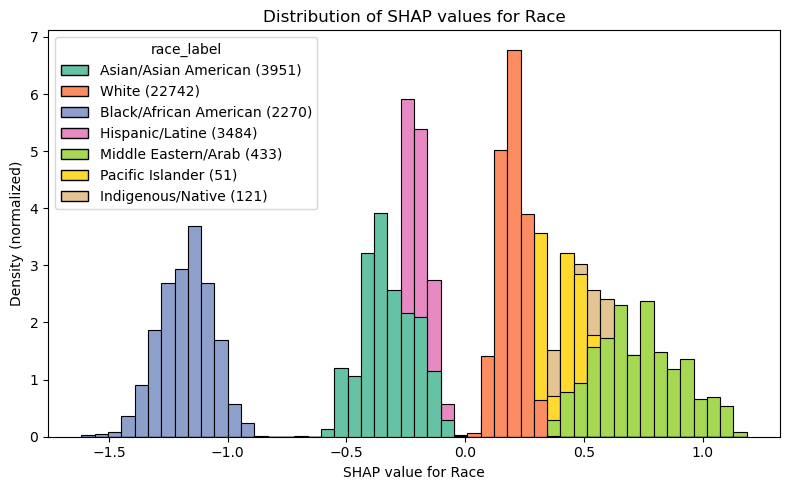

In [78]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_shap,
    x='race_shap',
    hue='race_label',
    bins=50,
    multiple='layer',    # overlay
    stat='density',      # <-- normalize within each race
    common_norm=False,   # <-- normalize per hue, not globally
    alpha=1,
    palette='Set2'
)
plt.xlabel("SHAP value for Race")
plt.ylabel("Density (normalized)")
plt.title("Distribution of SHAP values for Race")
plt.tight_layout()
plt.show()

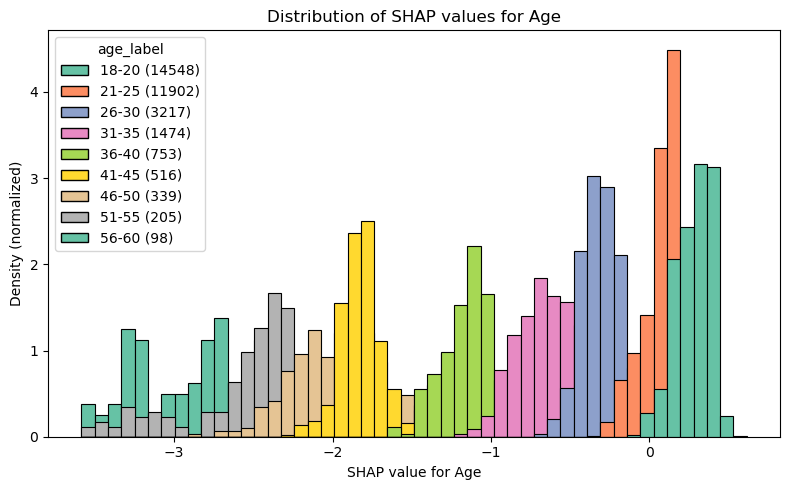

In [79]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_shap,
    x='age_shap',
    hue='age_label',
    bins=50,
    multiple='layer',    # overlay
    stat='density',      # <-- normalize within each race
    common_norm=False,   # <-- normalize per hue, not globally
    alpha=1,
    palette='Set2'
)
plt.xlabel("SHAP value for Age")
plt.ylabel("Density (normalized)")
plt.title("Distribution of SHAP values for Age")
plt.tight_layout()
plt.show()

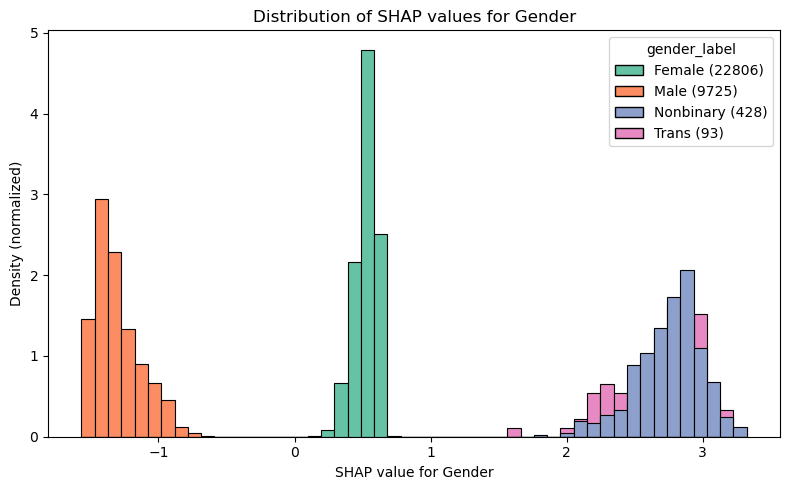

In [80]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_shap,
    x='gender_shap',
    hue='gender_label',
    bins=50,
    multiple='layer',    # overlay
    stat='density',      # <-- normalize within each race
    common_norm=False,   # <-- normalize per hue, not globally
    alpha=1,
    palette='Set2',
)
plt.xlabel("SHAP value for Gender")
plt.ylabel("Density (normalized)")
plt.title("Distribution of SHAP values for Gender")
plt.tight_layout()
plt.show()

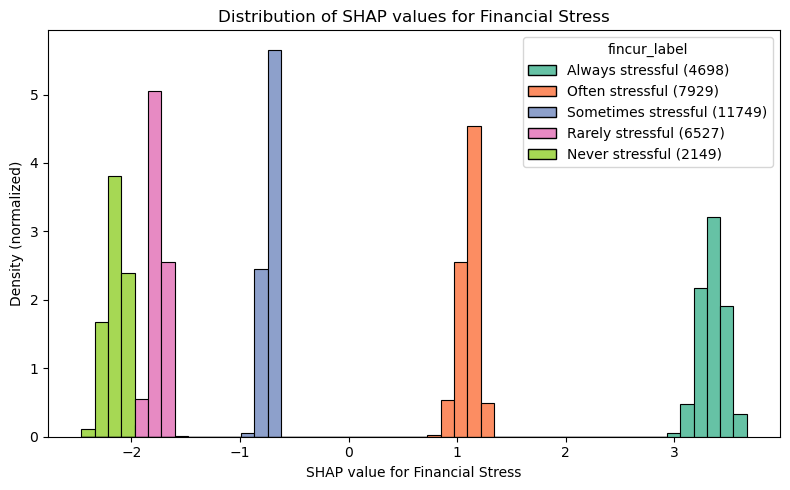

In [81]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_shap,
    x='fincur_shap',
    hue='fincur_label',
    bins=50,
    multiple='layer',    # overlay
    stat='density',      # <-- normalize within each race
    common_norm=False,   # <-- normalize per hue, not globally
    alpha=1,
    palette='Set2',
    hue_order=df_shap['fincur_label'].cat.categories
)
plt.xlabel("SHAP value for Financial Stress")
plt.ylabel("Density (normalized)")
plt.title("Distribution of SHAP values for Financial Stress")
plt.tight_layout()
plt.show()

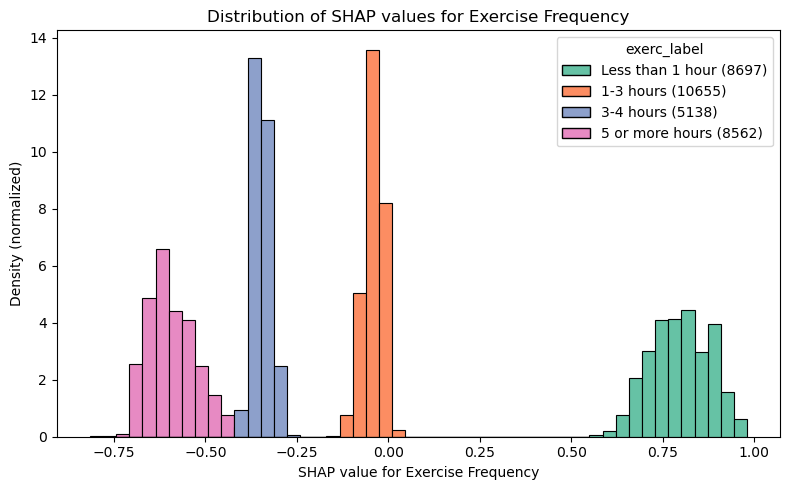

In [82]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_shap,
    x='exerc_shap',
    hue='exerc_label',
    bins=50,
    multiple='layer',    # overlay
    stat='density',      # <-- normalize within each race
    common_norm=False,   # <-- normalize per hue, not globally
    alpha=1,
    palette='Set2',
    hue_order=df_shap['exerc_label'].cat.categories
)
plt.xlabel("SHAP value for Exercise Frequency")
plt.ylabel("Density (normalized)")
plt.title("Distribution of SHAP values for Exercise Frequency")
plt.tight_layout()
plt.show()

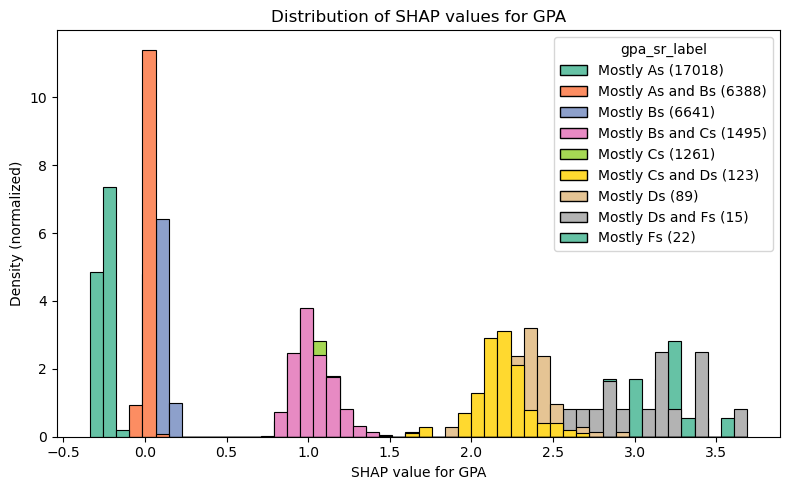

In [83]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_shap,
    x='gpa_sr_shap',
    hue='gpa_sr_label',
    bins=50,
    multiple='layer',    # overlay
    stat='density',      # <-- normalize within each race
    common_norm=False,   # <-- normalize per hue, not globally
    alpha=1,
    palette='Set2',
    hue_order=df_shap['gpa_sr_label'].cat.categories
)
plt.xlabel("SHAP value for GPA")
plt.ylabel("Density (normalized)")
plt.title("Distribution of SHAP values for GPA")
plt.tight_layout()
plt.show()

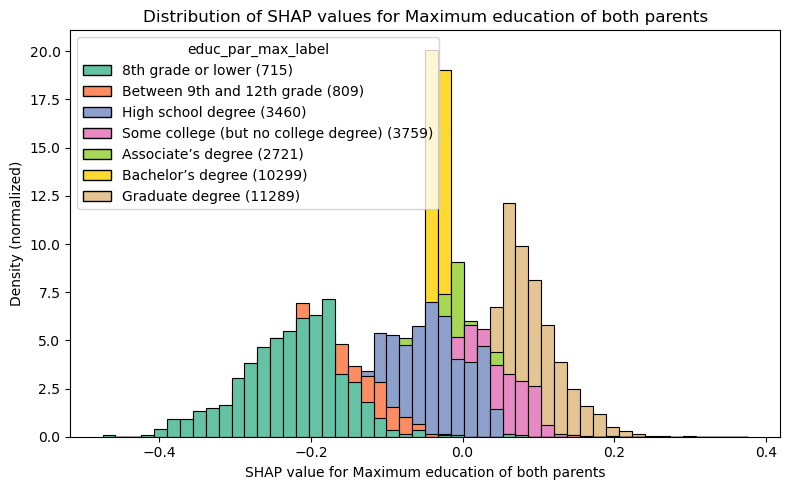

In [84]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_shap,
    x='educ_par_max_shap',
    hue='educ_par_max_label',
    bins=50,
    multiple='layer',    # overlay
    stat='density',      # <-- normalize within each race
    common_norm=False,   # <-- normalize per hue, not globally
    alpha=1,
    palette='Set2',
    hue_order=df_shap['educ_par_max_label'].cat.categories
)
plt.xlabel("SHAP value for Maximum education of both parents")
plt.ylabel("Density (normalized)")
plt.title("Distribution of SHAP values for Maximum education of both parents")
plt.tight_layout()
plt.show()

### Code for Depression Score

In [130]:
df_clean_train = df_train[['deprawsc', 'fincur','age','gender','race', 'educ_par_max', 'residenc', 'international', 'degree', 'gpa_sr', 'alc_any', 'exerc']]
df_clean_train = df_clean_train.dropna()

mask = df_clean_train['gpa_sr'] < 6
df_clean_train = df_clean_train[mask]
df_clean_train['gpa_sr'] = df_clean_train['gpa_sr']*2
df_clean_train = df_clean_train.astype('int64')

df_clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129911 entries, 0 to 90081
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   deprawsc       129911 non-null  int64
 1   fincur         129911 non-null  int64
 2   age            129911 non-null  int64
 3   gender         129911 non-null  int64
 4   race           129911 non-null  int64
 5   educ_par_max   129911 non-null  int64
 6   residenc       129911 non-null  int64
 7   international  129911 non-null  int64
 8   degree         129911 non-null  int64
 9   gpa_sr         129911 non-null  int64
 10  alc_any        129911 non-null  int64
 11  exerc          129911 non-null  int64
dtypes: int64(12)
memory usage: 12.9 MB


In [131]:
df_clean_val = df_val[['deprawsc', 'fincur','age','gender','race', 'educ_par_max', 'residenc', 'international', 'degree', 'gpa_sr', 'alc_any', 'exerc']]
df_clean_val = df_clean_val.dropna()

mask = df_clean_val['gpa_sr'] < 6
df_clean_val = df_clean_val[mask]
df_clean_val['gpa_sr'] = df_clean_val['gpa_sr']*2
df_clean_val = df_clean_val.astype('int64')

df_clean_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32664 entries, 3 to 60055
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   deprawsc       32664 non-null  int64
 1   fincur         32664 non-null  int64
 2   age            32664 non-null  int64
 3   gender         32664 non-null  int64
 4   race           32664 non-null  int64
 5   educ_par_max   32664 non-null  int64
 6   residenc       32664 non-null  int64
 7   international  32664 non-null  int64
 8   degree         32664 non-null  int64
 9   gpa_sr         32664 non-null  int64
 10  alc_any        32664 non-null  int64
 11  exerc          32664 non-null  int64
dtypes: int64(12)
memory usage: 3.2 MB


In [132]:
X_train = df_clean_train[['fincur','age','gender','race', 'educ_par_max', 'residenc', 'international', 'degree', 'gpa_sr', 'alc_any', 'exerc']]
y_train = df_clean_train['deprawsc']

X_val = df_clean_val[['fincur','age','gender','race', 'educ_par_max', 'residenc', 'international', 'degree', 'gpa_sr', 'alc_any', 'exerc']]
y_val = df_clean_val['deprawsc']

In [133]:
# Define categorical feature names or indices
categorical_features = ['gender', 'race', 'educ_par_max', 'residenc', 'international', 'degree', 'alc_any']

# Create CatBoost Pool
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
val_pool  = Pool(data=X_val,  label=y_val,  cat_features=categorical_features)

In [134]:
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.06056025600204656,
    depth=5,
    bagging_temperature=0.49828012041620684,
    l2_leaf_reg=9.591292715182213,
    min_data_in_leaf=27,
    random_strength=1.2665177187798482,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=22,
    verbose=100
)

model.fit(train_pool, eval_set=val_pool)

0:	learn: 6.1189855	test: 6.0982874	best: 6.0982874 (0)	total: 155ms	remaining: 2m 34s
100:	learn: 5.5785551	test: 5.5323047	best: 5.5323047 (100)	total: 2.14s	remaining: 19s
200:	learn: 5.5665984	test: 5.5226535	best: 5.5226535 (200)	total: 3.59s	remaining: 14.3s
300:	learn: 5.5607256	test: 5.5198260	best: 5.5198260 (300)	total: 5.08s	remaining: 11.8s
400:	learn: 5.5571955	test: 5.5184294	best: 5.5184293 (399)	total: 6.19s	remaining: 9.24s
500:	learn: 5.5546343	test: 5.5179003	best: 5.5179003 (500)	total: 7.35s	remaining: 7.32s
600:	learn: 5.5517163	test: 5.5173803	best: 5.5173571 (597)	total: 8.82s	remaining: 5.86s
700:	learn: 5.5498091	test: 5.5172532	best: 5.5172199 (687)	total: 10.1s	remaining: 4.32s
800:	learn: 5.5477622	test: 5.5171484	best: 5.5170996 (754)	total: 11.4s	remaining: 2.83s
900:	learn: 5.5461198	test: 5.5170266	best: 5.5170256 (878)	total: 12.6s	remaining: 1.38s
999:	learn: 5.5442014	test: 5.5169722	best: 5.5168909 (928)	total: 14.2s	remaining: 0us

bestTest = 5.516

In [90]:
print('MSE = ', str(5.516890885**2))

r2_catboost = model.score(X_val, y_val)

print('r2 (catboost) = ', r2_catboost)

MSE =  30.43608503699608
r2 (catboost) =  0.19562318281746416


In [91]:
threshold = y_val.median()
print(threshold)

7.0


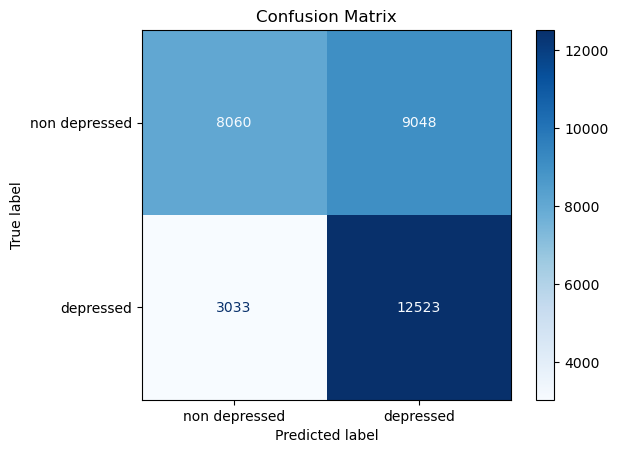

accuracy =  63.01432770022043
precision =  58.05479579064484
recall =  80.50269992285935
f1 =  67.46033883696501


In [92]:
preds = model.predict(val_pool)

preds_depr = (preds > threshold).astype(int)
y_val_depr = (y_val > threshold).astype(int)

cm = confusion_matrix(y_val_depr, preds_depr)

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

# Define display labels if desired
display_labels = ['non depressed', 'depressed']

# Create a display object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Plot the matrix
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print('accuracy = ', str(accuracy*100))
print('precision = ', str(precision*100))
print('recall = ', str(recall*100))
print('f1 = ', str(f1*100))

In [136]:
importances = model.get_feature_importance(val_pool)
feature_importance = sorted(zip(X_train.columns, importances), key=lambda x: -x[1])

print(feature_importance)

[('fincur', np.float64(43.33947257380905)), ('gpa_sr', np.float64(13.533284870258562)), ('exerc', np.float64(13.038531623790998)), ('age', np.float64(9.9040763676505)), ('gender', np.float64(9.499322638989385)), ('race', np.float64(3.4754818507631464)), ('alc_any', np.float64(2.6425009659621157)), ('degree', np.float64(1.94572516294777)), ('educ_par_max', np.float64(1.3420367722162512)), ('residenc', np.float64(1.0819677002036034)), ('international', np.float64(0.19759947340859504))]
